In [6]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [7]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [8]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [9]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [10]:
metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")

In [11]:
metadata["OS-event"]

0     0.0
1     0.0
2     1.0
3     0.0
4     0.0
     ... 
89    0.0
90    0.0
91    0.0
92    0.0
93    0.0
Name: OS-event, Length: 94, dtype: float64

In [12]:
metadata["OS_years"]

0      8.284932
1     11.282192
2      2.375342
3      5.156164
4      6.756164
        ...    
89    20.186301
90    15.769863
91     3.183562
92     5.065753
93     7.520548
Name: OS_years, Length: 94, dtype: float64

In [13]:
metadata["above_56"] = (metadata["Age_at_diagnosis"] > 56).astype(int)

In [14]:
metadata["Age_at_diagnosis"].min()

np.int64(24)

In [15]:
metadata["Age_at_diagnosis"].describe()

count    94.00000
mean     56.12766
std      15.09485
min      24.00000
25%      43.25000
50%      56.00000
75%      68.00000
max      87.00000
Name: Age_at_diagnosis, dtype: float64

In [16]:
# Statistical test: Log-rank test to compare survival curves
from lifelines.statistics import logrank_test

# Prepare data
data_km = metadata[['OS_years', 'OS-event', 'above_56']].dropna()

# Separate groups
group_young = data_km[data_km['above_56'] == 0]
group_old = data_km[data_km['above_56'] == 1]

# Perform log-rank test
results = logrank_test(
    group_young['OS_years'], 
    group_old['OS_years'],
    event_observed_A=group_young['OS-event'],
    event_observed_B=group_old['OS-event']
)

print("Log-rank test results:")
print(f"Test statistic: {results.test_statistic:.4f}")
print(f"P-value: {results.p_value:.4f}")
print(f"Significance: {'Yes' if results.p_value < 0.05 else 'No'} (α = 0.05)")

Log-rank test results:
Test statistic: 10.2897
P-value: 0.0013
Significance: Yes (α = 0.05)


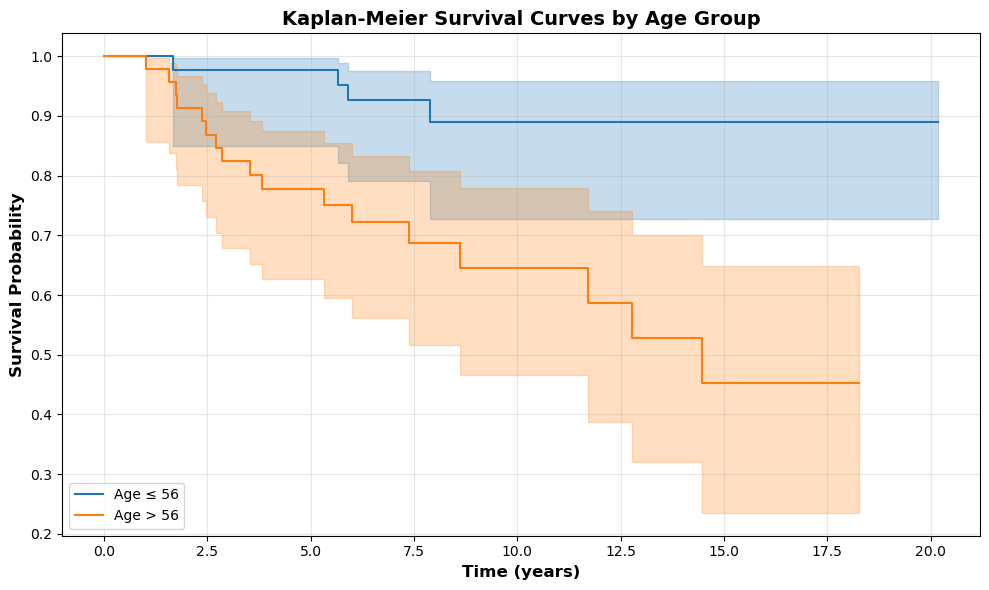

Number of patients: Age ≤ 56: 45, Age > 56: 47


In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Prepare the data - remove any NaN values
data_km = metadata[['OS_years', 'OS-event', 'above_56']].dropna()

# Plot Kaplan-Meier curves for both groups
fig, ax = plt.subplots(figsize=(10, 6))

# Group 0: Age <= 56
mask_young = data_km['above_56'] == 0
kmf.fit(data_km.loc[mask_young, 'OS_years'], 
        data_km.loc[mask_young, 'OS-event'], 
        label='Age ≤ 56')
kmf.plot_survival_function(ax=ax, ci_show=True)

# Group 1: Age > 56
mask_old = data_km['above_56'] == 1
kmf.fit(data_km.loc[mask_old, 'OS_years'], 
        data_km.loc[mask_old, 'OS-event'], 
        label='Age > 56')
kmf.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Probability', fontsize=12, fontweight='bold')
ax.set_title('Kaplan-Meier Survival Curves by Age Group', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print(f"Number of patients: Age ≤ 56: {mask_young.sum()}, Age > 56: {mask_old.sum()}")

In [19]:
# Extract patient IDs from the spot names in df
# Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
df['patient_id'] = df.index.str.split('_').str[0]

# Count spots per cluster per patient
cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

# Calculate total spots per patient
total_spots = df.groupby('patient_id').size().reset_index(name='total')

# Merge and calculate percentages
cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

# Pivot to get one row per patient with columns for each cluster
cluster_composition_wide = cluster_composition.pivot(
    index='patient_id', 
    columns='predicted_label', 
    values='percentage'
).fillna(0)

# Rename columns to be more descriptive
cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]

print(f"Cluster composition for {len(cluster_composition_wide)} patients:")
cluster_composition_wide

Cluster composition for 85 patients:


,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct
patient_id,,,,,,
TNBC1,80.952381,0.000000,0.000000,19.047619,0.000000,0.000000
TNBC11,5.750351,0.000000,93.688640,0.561010,0.000000,0.000000
TNBC12,26.666667,0.000000,13.333333,56.666667,3.333333,0.000000
TNBC13,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
TNBC14,18.922652,35.911602,0.414365,33.287293,11.049724,0.414365
...,...,...,...,...,...,...
TNBC92,24.296296,22.444444,1.185185,41.481481,8.444444,2.148148
TNBC93,4.759329,1.189832,0.108167,6.652244,85.343429,1.946998
TNBC94,23.295455,0.284091,62.713068,12.215909,1.278409,0.213068


In [ ]:
# Merge cluster composition with clinical metadata
# First, match patient IDs between cluster data and metadata
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed



Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


,cluster_0_pct,cluster_1_pct,cluster_2_pct,cluster_3_pct,cluster_4_pct,cluster_5_pct,patient_id,OS_years,OS-event,Age_at_diagnosis
0,80.952381,0.000000,0.000000,19.047619,0.000000,0.000000,TNBC1,8.284932,0.0,66
2,5.750351,0.000000,93.688640,0.561010,0.000000,0.000000,TNBC11,2.375342,1.0,67
3,26.666667,0.000000,13.333333,56.666667,3.333333,0.000000,TNBC12,5.156164,0.0,61
4,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,TNBC13,6.756164,0.0,72
5,18.922652,35.911602,0.414365,33.287293,11.049724,0.414365,TNBC14,6.816438,0.0,35


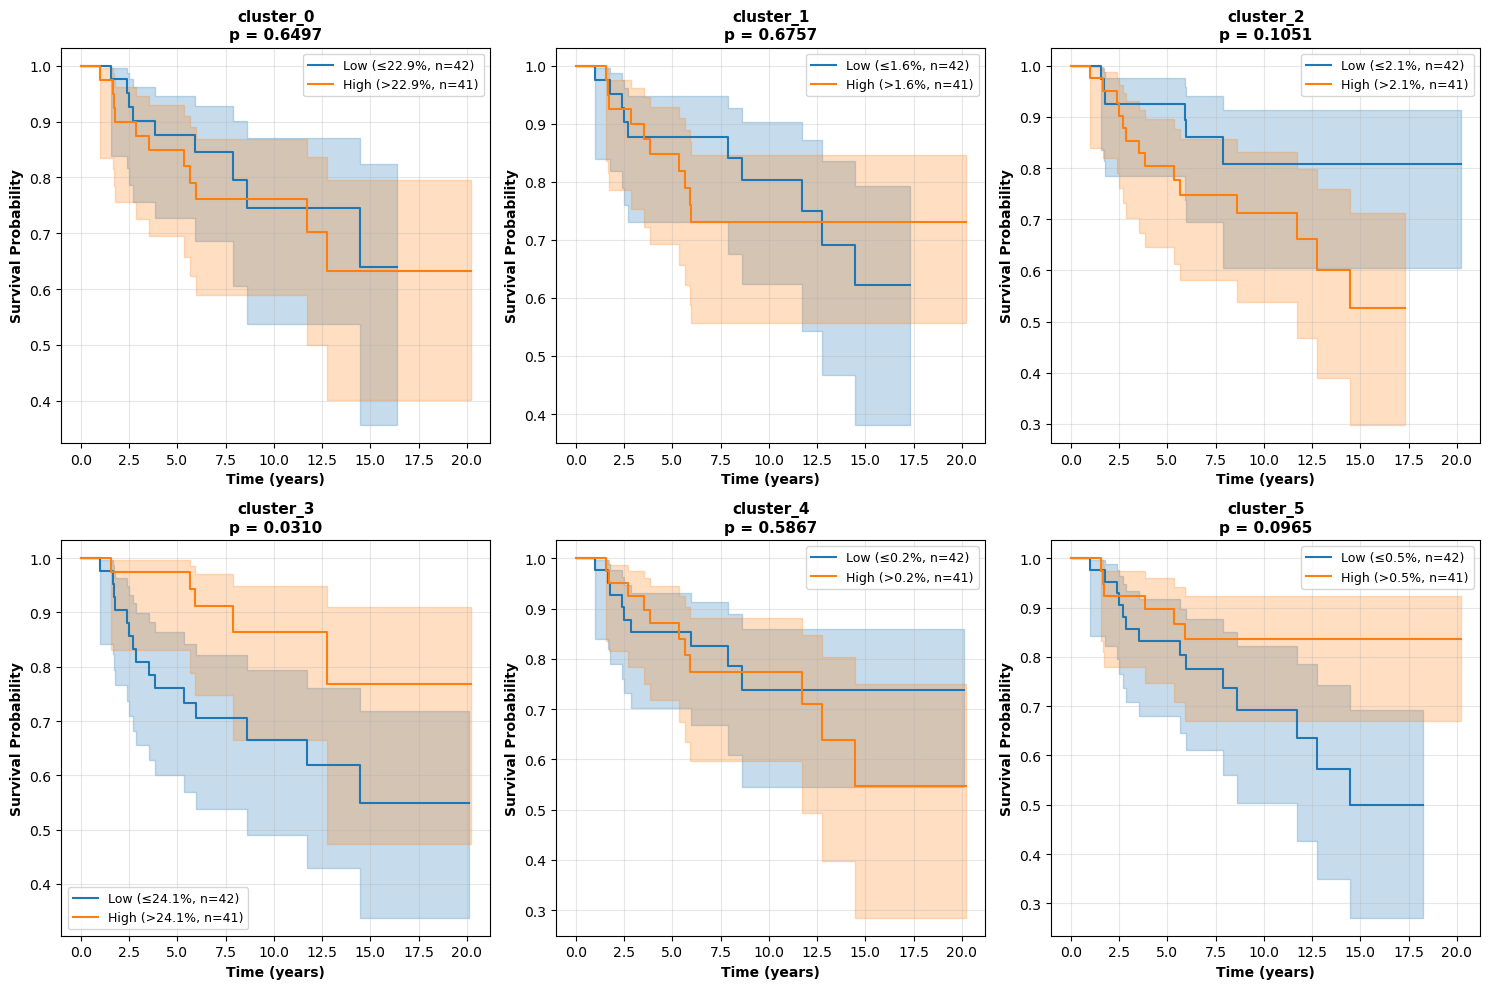


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.649723,0.206250
1,cluster_1,1.612903,42,41,0.675724,0.174980
2,cluster_2,2.139037,42,41,0.105094,2.626482
3,cluster_3,24.081633,42,41,0.030967,4.654775
4,cluster_4,0.202429,42,41,0.586670,0.295575
5,cluster_5,0.530504,42,41,0.096528,2.761987


In [ ]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


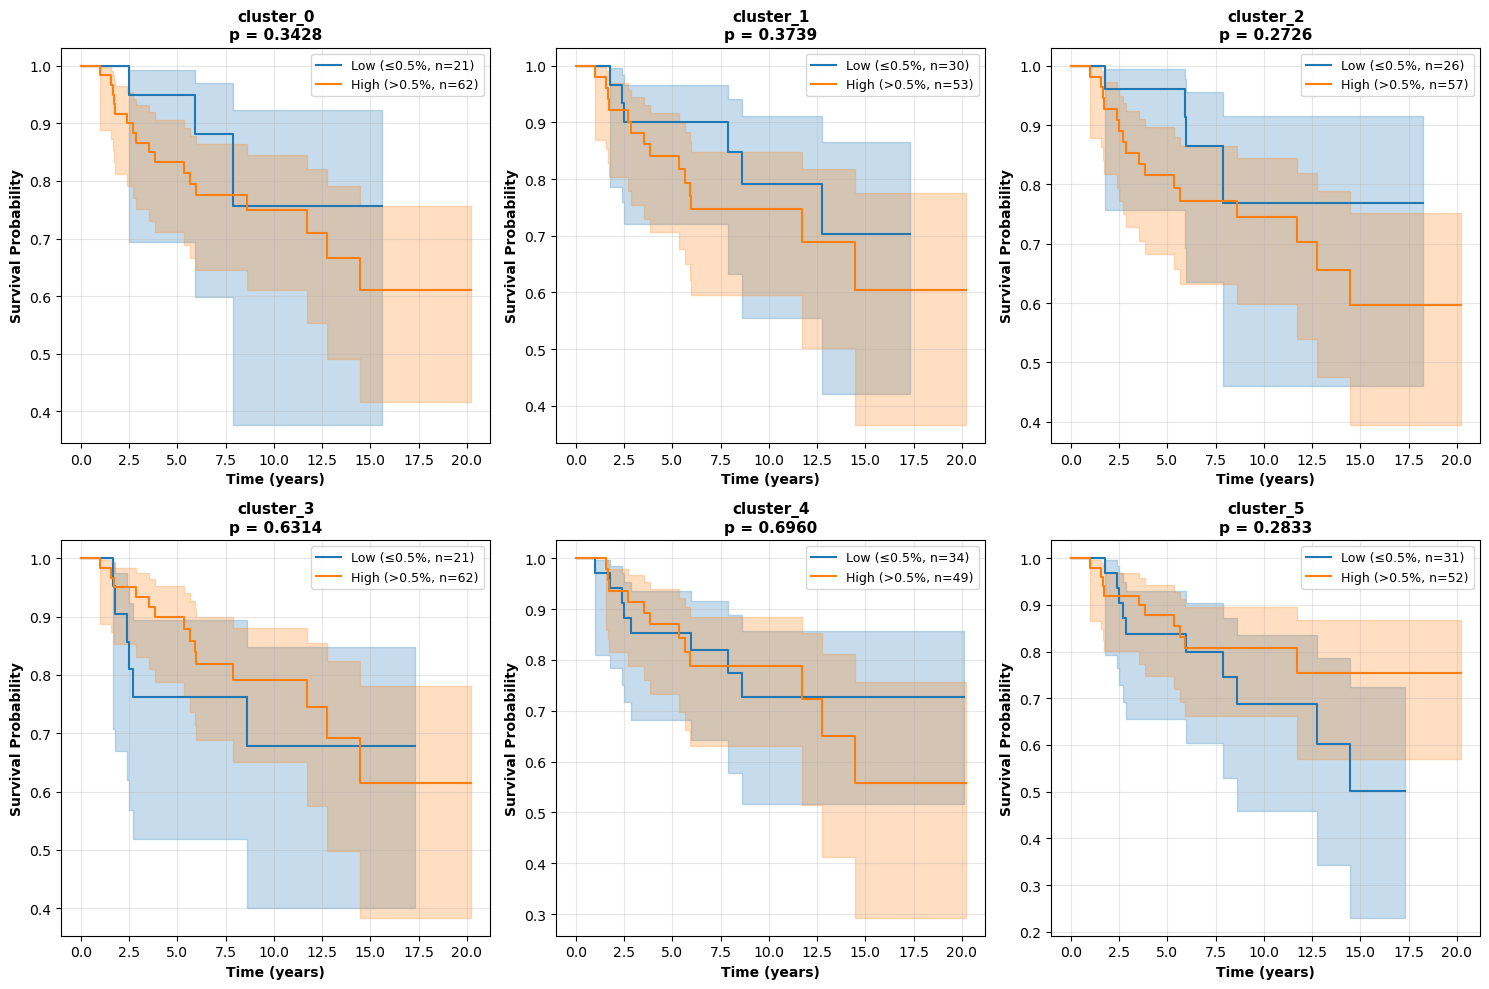


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,0.530504,21,62,0.342791,0.899967
1,cluster_1,0.530504,30,53,0.373936,0.790542
2,cluster_2,0.530504,26,57,0.272618,1.203528
3,cluster_3,0.530504,21,62,0.631427,0.230131
4,cluster_4,0.530504,34,49,0.696019,0.152647
5,cluster_5,0.530504,31,52,0.283321,1.151088


In [38]:

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['OS_years', 'OS-event', cluster_col]].dropna()
    
    # Split by median
    third_quartile = data_clean[cluster_col].quantile(0.25)
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > third_quartile]
    low_group = data_clean[data_clean[cluster_col] <= third_quartile]
    
    # Plot low group
    kmf.fit(low_group['OS_years'], 
            low_group['OS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['OS_years'], 
            high_group['OS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['OS_years'], 
        high_group['OS_years'],
        event_observed_A=low_group['OS-event'],
        event_observed_B=high_group['OS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

In [27]:
# Highlight significant clusters (p < 0.05)
significant_clusters = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

if len(significant_clusters) > 0:
    print(f"\n⭐ Significant clusters (p < 0.05):")
    print(significant_clusters)
else:
    print("\nNo clusters showed significant association with survival (p < 0.05)")


⭐ Significant clusters (p < 0.05):
     cluster  median_split  n_low  n_high   p_value  test_statistic
3  cluster_3     24.081633     42      41  0.030967        4.654775


In [29]:
metadata['iBCFS-event']

0     0.0
1     0.0
2     1.0
3     0.0
4     1.0
     ... 
89    1.0
90    0.0
91    0.0
92    0.0
93    0.0
Name: iBCFS-event, Length: 94, dtype: float64

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


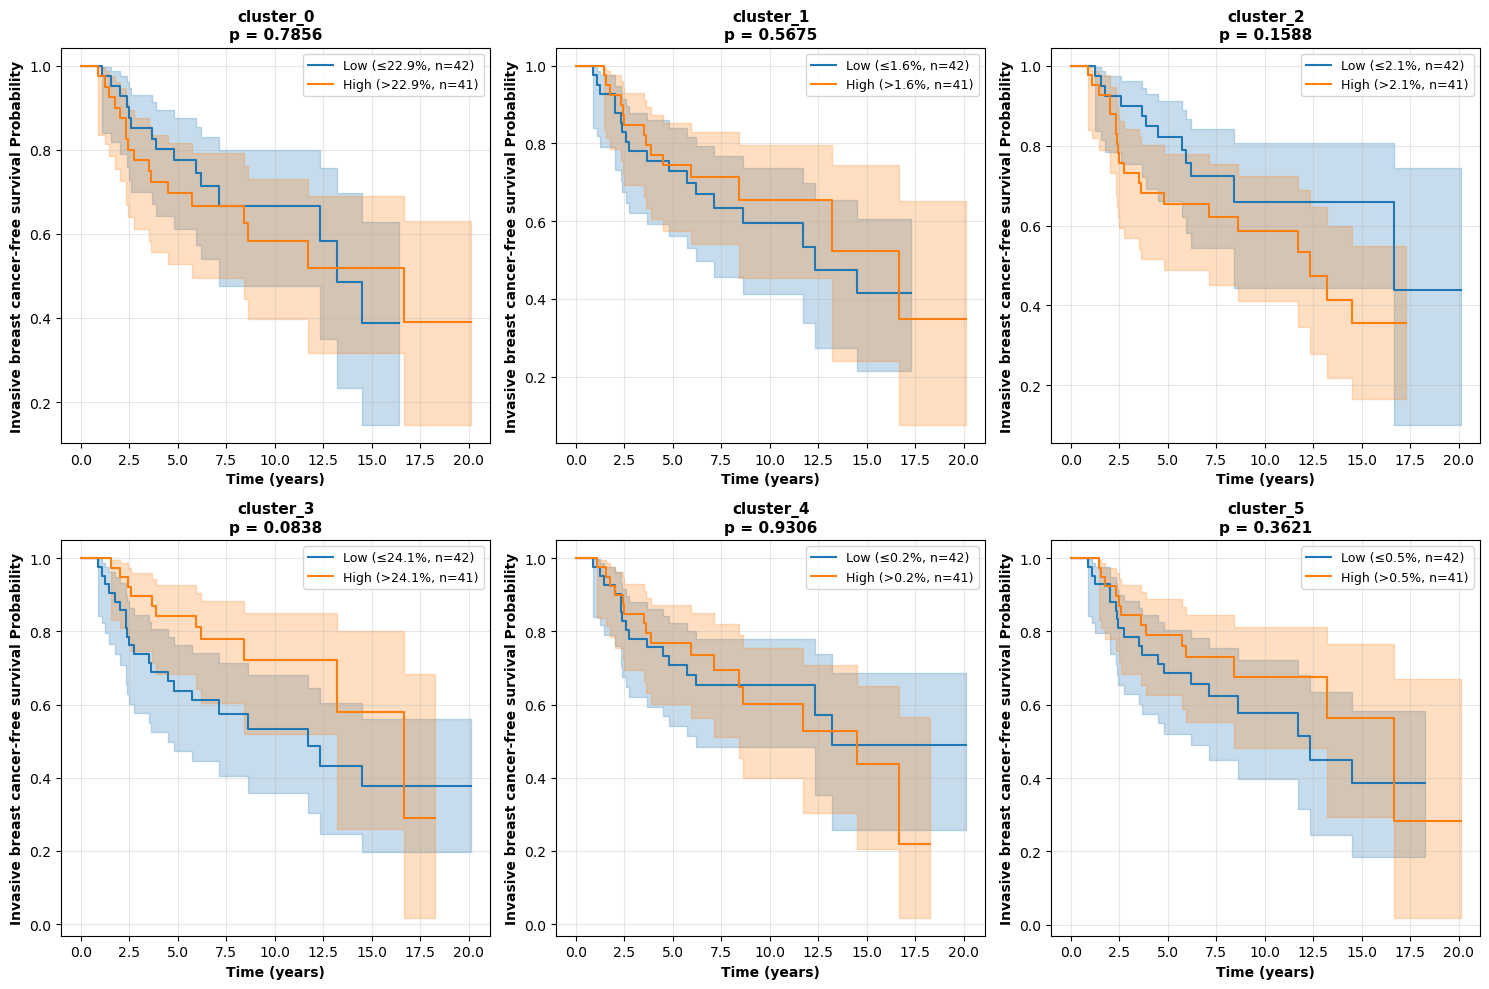


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.785611,0.073992
1,cluster_1,1.612903,42,41,0.567531,0.326831
2,cluster_2,2.139037,42,41,0.158814,1.985485
3,cluster_3,24.081633,42,41,0.083755,2.990495
4,cluster_4,0.202429,42,41,0.930593,0.007586
5,cluster_5,0.530504,42,41,0.362126,0.830506


In [31]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'iBCFS_years', 'iBCFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['iBCFS_years', 'iBCFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['iBCFS_years'], 
            low_group['iBCFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['iBCFS_years'], 
            high_group['iBCFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['iBCFS_years'], 
        high_group['iBCFS_years'],
        event_observed_A=low_group['iBCFS-event'],
        event_observed_B=high_group['iBCFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Invasive breast cancer-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


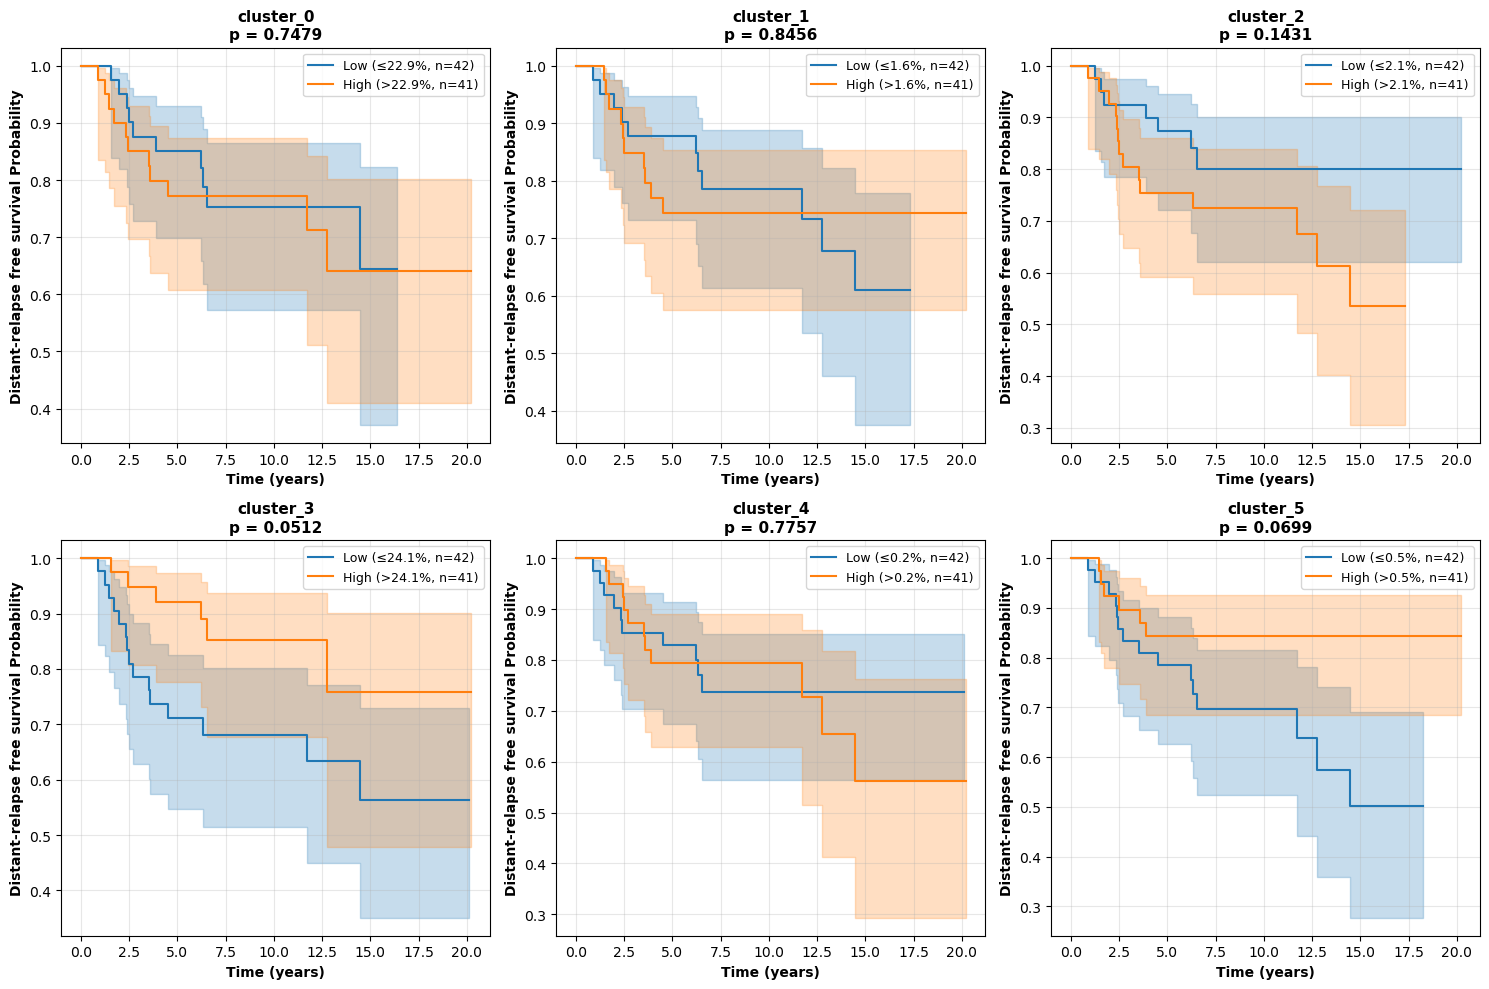


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.747907,0.103298
1,cluster_1,1.612903,42,41,0.845590,0.037927
2,cluster_2,2.139037,42,41,0.143067,2.144659
3,cluster_3,24.081633,42,41,0.051155,3.803185
4,cluster_4,0.202429,42,41,0.775701,0.081183
5,cluster_5,0.530504,42,41,0.069880,3.285828


In [33]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'DRFS_years', 'DRFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['DRFS_years', 'DRFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['DRFS_years'], 
            low_group['DRFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['DRFS_years'], 
            high_group['DRFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['DRFS_years'], 
        high_group['DRFS_years'],
        event_observed_A=low_group['DRFS-event'],
        event_observed_B=high_group['DRFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Distant-relapse free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


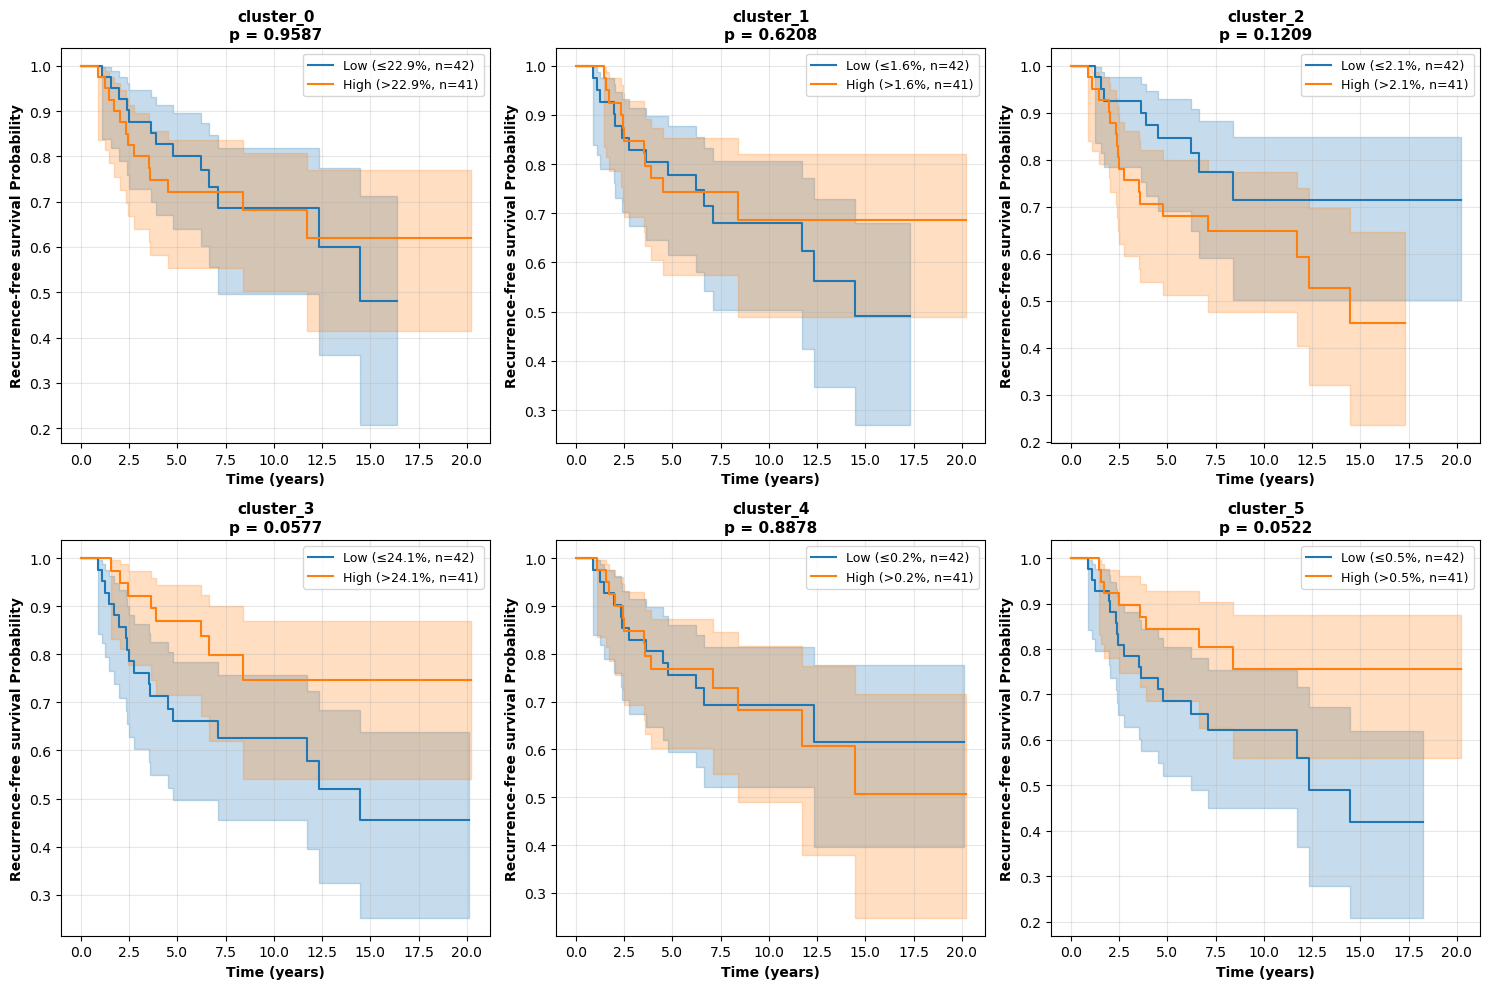


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.958671,0.002685
1,cluster_1,1.612903,42,41,0.620783,0.244769
2,cluster_2,2.139037,42,41,0.120919,2.405379
3,cluster_3,24.081633,42,41,0.057684,3.602755
4,cluster_4,0.202429,42,41,0.887751,0.019923
5,cluster_5,0.530504,42,41,0.052167,3.770400


In [35]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'RFS_years', 'RFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['RFS_years', 'RFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['RFS_years'], 
            low_group['RFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['RFS_years'], 
            high_group['RFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['RFS_years'], 
        high_group['RFS_years'],
        event_observed_A=low_group['RFS-event'],
        event_observed_B=high_group['RFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Recurrence-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df

Merged data for 85 patients with survival information:
Cluster columns: ['cluster_0_pct', 'cluster_1_pct', 'cluster_2_pct', 'cluster_3_pct', 'cluster_4_pct', 'cluster_5_pct']


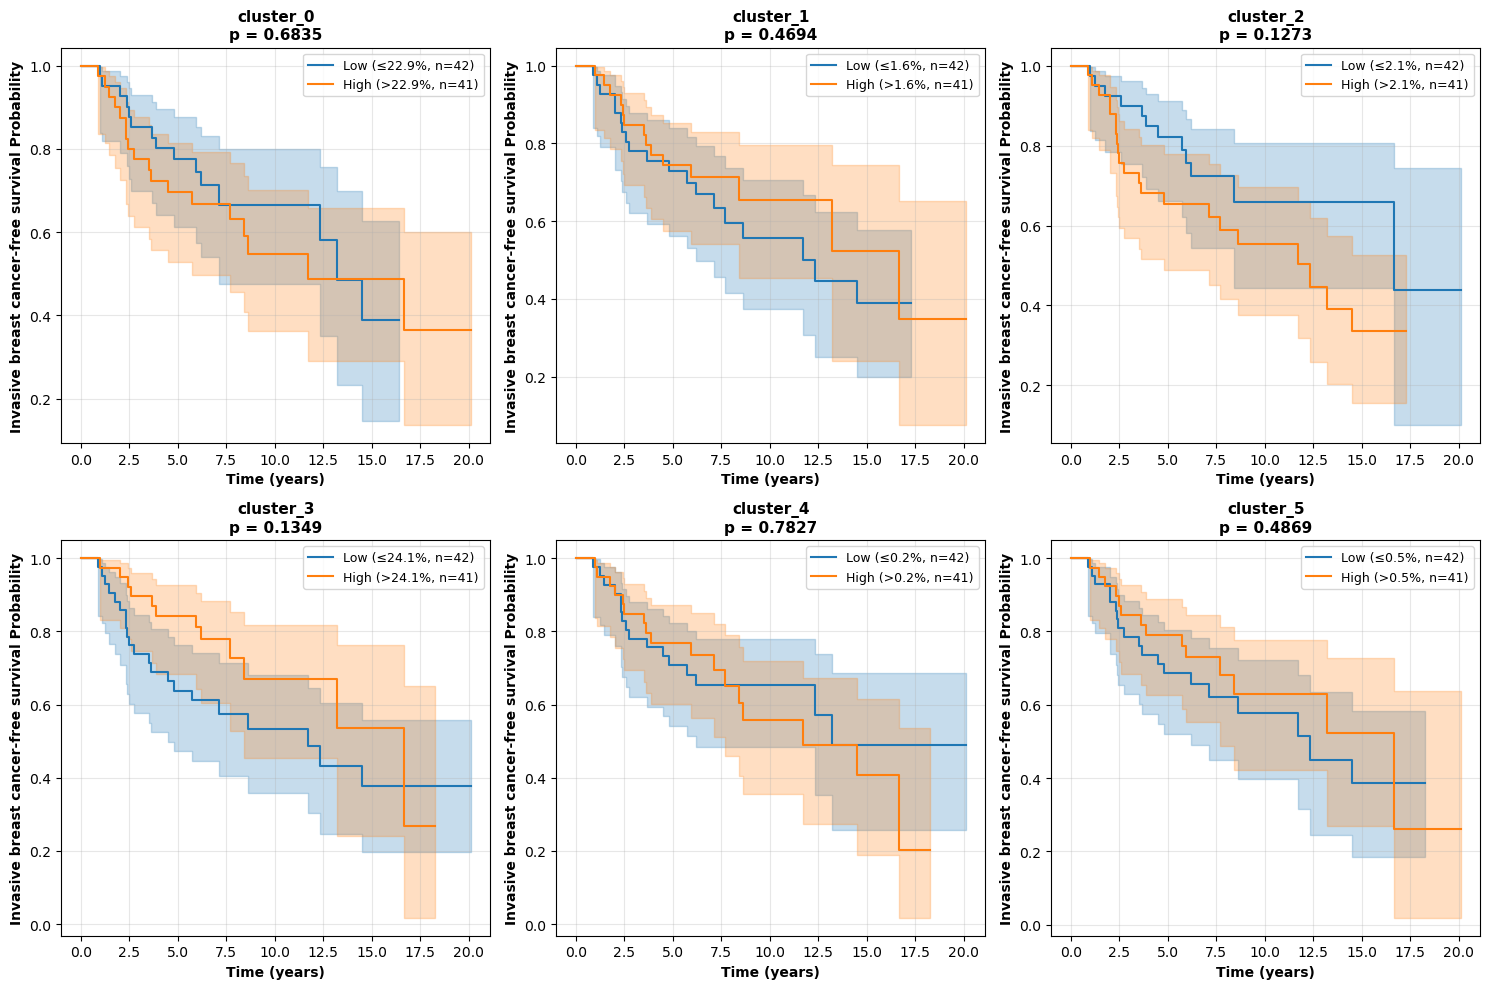


Log-rank test results for all clusters:


,cluster,median_split,n_low,n_high,p_value,test_statistic
0,cluster_0,22.857143,42,41,0.683527,0.166183
1,cluster_1,1.612903,42,41,0.469426,0.523327
2,cluster_2,2.139037,42,41,0.127260,2.325614
3,cluster_3,24.081633,42,41,0.134854,2.235717
4,cluster_4,0.202429,42,41,0.782718,0.076054
5,cluster_5,0.530504,42,41,0.486871,0.483434


In [36]:
# Create groups based on cluster composition
# Strategy: For each cluster, divide patients into high vs low percentage groups using median split

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Merge the dataframes
patient_data = cluster_composition_wide.merge(
    metadata[['patient_id', 'iDFS_years', 'iDFS-event', 'Age_at_diagnosis']], 
    left_index=True, 
    right_on='patient_id',
    how='inner'
)

print(f"Merged data for {len(patient_data)} patients with survival information:")
print(f"Cluster columns: {[col for col in patient_data.columns if 'cluster' in col]}")
patient_data.head()

# Get cluster columns
cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]

# Create a figure with subplots for each cluster
n_clusters = len(cluster_cols)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_clusters > 1 else [axes]

kmf = KaplanMeierFitter()

results_summary = []

for idx, cluster_col in enumerate(cluster_cols):
    ax = axes[idx]
    
    # Remove NaN values for this cluster
    data_clean = patient_data[['iDFS_years', 'iDFS-event', cluster_col]].dropna()
    
    # Split by median
    median_val = data_clean[cluster_col].median()
    
    # Create groups
    high_group = data_clean[data_clean[cluster_col] > median_val]
    low_group = data_clean[data_clean[cluster_col] <= median_val]
    
    # Plot low group
    kmf.fit(low_group['iDFS_years'], 
            low_group['iDFS-event'], 
            label=f'Low (≤{median_val:.1f}%, n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Plot high group
    kmf.fit(high_group['iDFS_years'], 
            high_group['iDFS-event'], 
            label=f'High (>{median_val:.1f}%, n={len(high_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Log-rank test
    results = logrank_test(
        low_group['iDFS_years'], 
        high_group['iDFS_years'],
        event_observed_A=low_group['iDFS-event'],
        event_observed_B=high_group['iDFS-event']
    )
    
    # Store results
    cluster_name = cluster_col.replace('_pct', '')
    results_summary.append({
        'cluster': cluster_name,
        'median_split': median_val,
        'n_low': len(low_group),
        'n_high': len(high_group),
        'p_value': results.p_value,
        'test_statistic': results.test_statistic
    })
    
    # Formatting
    ax.set_xlabel('Time (years)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Invasive breast cancer-free survival Probability', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_name}\np = {results.p_value:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='best', fontsize=9)

# Remove empty subplots
for idx in range(n_clusters, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Display summary
results_df = pd.DataFrame(results_summary)
print("\nLog-rank test results for all clusters:")
results_df